In [12]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
train = pd.read_csv('train_data_regression_model')
train = train.iloc[:,1:]
train = train.rename(columns={"1stD": "First_Downs", "Att.1": "Att_First", "Y/P":"YpP", "Y/A":"YpA", "Rush_1stD":"Rush_Firsts", "TO%":"TOPerc"})
train

test = pd.read_csv('Test Data')
test = test.iloc[:,1:]
test = test.rename(columns={"1stD": "First_Downs", "Att.1": "Att_First", "Y/P":"YpP", "Y/A":"YpA", "Rush_1stD":"Rush_Firsts", "TO%":"TOPerc"})
test

actual_wins = pd.read_csv('Actual Wins')
actual_wins = actual_wins.iloc[:,1:]
actual_wins
test = pd.merge(test,actual_wins)
test

,Rk,Tm,G,PF,Yds,Ply,YpP,TO,FL,First_Downs,...,Rush_TD,YpA,Rush_Firsts,Pen,Pen_Yds,1stPy,Sc%,TOPerc,EXP,W
0,1,Kansas City Chiefs,17,496,7032,1094,6.4,23,11,408,...,18,4.7,105,87,838,31,46.4,10.1,281.00,14
1,2,Philadelphia Eagles,17,477,6614,1124,5.9,19,10,385,...,32,4.6,161,90,682,29,42.5,10.2,226.96,14
2,3,Dallas Cowboys,17,467,6034,1114,5.4,23,5,347,...,24,4.3,129,104,842,24,41.5,10.8,112.34,12
3,4,Buffalo Bills,16,455,6361,1037,6.1,27,13,367,...,15,5.2,128,92,709,27,45.0,15.2,157.46,13
4,5,Detroit Lions,17,453,6460,1092,5.9,15,8,376,...,23,4.5,114,90,773,34,43.2,8.0,162.04,9
5,6,San Francisco 49ers,17,450,6216,1047,5.9,17,8,347,...,20,4.7,132,94,730,27,41.4,9.1,161.29,13
6,7,Minnesota Vikings,17,424,6145,1123,5.5,23,8,382,...,18,4.1,93,88,684,45,36.0,11.7,89.64,13
7,8,Cincinnati Bengals,16,418,5768,1053,5.5,18,6,357,...,14,3.8,96,81,623,40,41.5,9.7,147.62,12
8,9,Seattle Seahawks,17,407,5976,1044,5.7,23,11,346,...,12,4.8,106,106,854,34,40.6,11.2,63.60,9
9,10,Jacksonville Jaguars,17,404,6075,1072,5.7,22,13,352,...,16,4.7,114,90,674,30,39.2,12.2,103.21,9


In [4]:
# Naive Model
ols_object = smf.ols(formula = 'W~Yds+TO+FL+Cmp+Att+Pass_Yds+TD+Int+Rush_Yds+Rush_TD+Pen+Pen_Yds+First_Downs+Att_First+YpP+YpA+Rush_Firsts', data = train)
naive_model = ols_object.fit()
naive_model.summary()

# Insights: Yds not significant but touchdowns (obviously) are. Turnovers significant, but for some reason fumbles lost are not.
# Explore that by using interadtion Term. Completions and Attempts not significant. Even though yds not significant, the coefficient is 
# negative, surprisingly. Use only significant predictors for next iteration.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     22.20
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           3.12e-30
Time:                        15:14:40   Log-Likelihood:                -312.58
No. Observations:                 160   AIC:                             657.2
Df Residuals:                     144   BIC:                             706.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -26.4933     17.545     -1.510      0.133     -61.172       8.186
Yds            -0.0042      0.003     -1.568      0.119      -0.010       0.001
TO             -0.0932      0.022     -4.216      0.000      -0.137      -0.049
FL             -0.0356      0.037     -0.968      0.335      -0.108       0.037
Cmp             0.0150      0.011      1.409      0.161      -0.006       0.036
Att             0.0119      0.015      0.778      0.438      -0.018       0.042
Pass_Yds       -0.0008      0.002     -0.393      0.695      -0.005       0.003
TD              0.1876      0.034      5.594      0.000       0.121       0.254
Int            -0.0576      0.032     -1.815      0.072      -0.120       0.005
Rush_Yds       -0.0034      0.004     -0.916      0.361      -0.011       0.004
Rush_TD         0.1909      0.053      3.614      0.000       0.086       0.295
Pen             0.0166      0.025      0.672      0.502      -0.032       0.065
Pen_Yds         0.0003      0.003      0.131      0.896      -0.005       0.005
First_Downs     0.0134      0.015      0.906      0.367      -0.016       0.043
Att_First       0.0592      0.028      2.117      0.036       0.004       0.114
YpP             4.1071      2.750      1.494      0.137      -1.328       9.542
YpA            -0.2076      2.242     -0.093      0.926      -4.640       4.225
Rush_Firsts    -0.0232      0.021     -1.092      0.277      -0.065       0.019
==============================================================================
Omnibus:                        4.509   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.550
Skew:                          -0.407   Prob(JB):                        0.103
Kurtosis:                       2.859   Cond. No.                     3.66e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.14e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [5]:
# Only use significant predictors at 10% level: eliminate most insignificant variables until all are significant
# some counterintuitive negative coefficients. this is because "all else held equal"
ols_object = smf.ols(formula = 'W~TO+Cmp+Att+First_Downs+Att_First+YpP+Rush_Firsts+TOPerc+Ply+PF+I(Att_First**2)+I(Att_First**3)', data = train)
model1 = ols_object.fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     38.79
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           1.57e-39
Time:                        15:14:40   Log-Likelihood:                -294.23
No. Observations:                 160   AIC:                             614.5
Df Residuals:                     147   BIC:                             654.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -47.0485     46.384     -1.014      0.312    -138.714      44.617
TO                    0.1453      0.120      1.209      0.229      -0.092       0.383
Cmp                   0.0193      0.009      2.223      0.028       0.002       0.036
Att                   0.0307      0.015      2.027      0.044       0.001       0.061
First_Downs           0.0246      0.013      1.867      0.064      -0.001       0.051
Att_First             0.4534      0.311      1.459      0.147      -0.161       1.068
YpP                  -2.0406      0.599     -3.404      0.001      -3.225      -0.856
Rush_Firsts          -0.0317      0.013     -2.418      0.017      -0.058      -0.006
TOPerc               -0.5075      0.236     -2.153      0.033      -0.973      -0.042
Ply                  -0.0567      0.015     -3.668      0.000      -0.087      -0.026
PF                    0.0277      0.005      6.029      0.000       0.019       0.037
I(Att_First ** 2)    -0.0008      0.001     -1.188      0.237      -0.002       0.001
I(Att_First ** 3)  5.739e-07    5.1e-07      1.125      0.262   -4.34e-07    1.58e-06
==============================================================================
Omnibus:                        1.952   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.646
Skew:                          -0.243   Prob(JB):                        0.439
Kurtosis:                       3.102   Cond. No.                     3.24e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

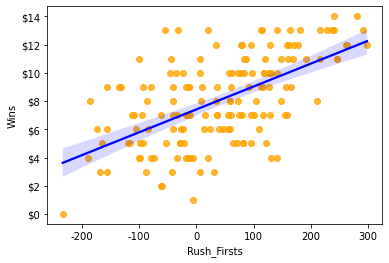

In [6]:
# Variable Transformations
ax = sns.regplot(x = train.EXP, y =train.W,color = 'orange', line_kws = {'color':'blue'})
plt.xlabel('Rush_Firsts')
plt.ylabel('Wins')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')

#ols_object = smf.ols(formula = 'W~Cmp+I(Cmp**2)', data = train)
#model = ols_object.fit()
#model.summary()
# ALL variables to seem to have linear relationship.

<AxesSubplot:xlabel='W'>

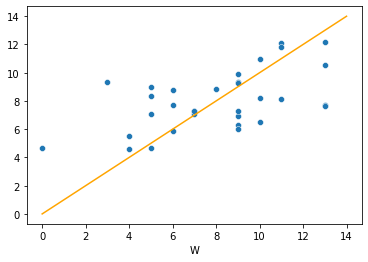

In [19]:
# Aware this is not prediction problem, but just for information
pred_wins = model1.predict(test)
sns.scatterplot(x = train.W, y = pred_wins)
sns.lineplot(x = [0,train.W.max()], y = [0,train.W.max()],color='orange')

In [29]:
RMSE = np.sqrt(((test.W - pred_wins)**2).mean())
RMSE

1.9605203170948056